In [1]:
import sys
sys.path.append('..')
from dataclasses import dataclass, field
from typing import Optional

import numpy as np

import torch
from torch.utils.data.dataset import Dataset
from torch.utils.data.dataloader import DataLoader

from transformers import AutoConfig, AutoModel, AutoModelForSequenceClassification, AutoTokenizer
from transformers import GlueDataTrainingArguments as DataTrainingArguments
from transformers import GlueDataset, default_data_collator

import seaborn
import matplotlib.pyplot as plt
from tqdm import tqdm

from hans.utils_hans import HansDataset, hans_processors

In [16]:
config = AutoConfig.from_pretrained('/home/nlp/experiments/google_bert/bert_tiny', 
                                    num_labels=3)

In [17]:
model = AutoModelForSequenceClassification.from_pretrained('/home/nlp/experiments/google_bert/bert_tiny/',
                                                          config=config)

Some weights of the model checkpoint at /home/nlp/experiments/google_bert/bert_tiny/ were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClass

In [22]:
tokenizer = AutoTokenizer.from_pretrained("prajjwal1/bert_small")

In [13]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=128, out_features=128, bias=True)
              (key): Linear(in_features=128, out_features=128, bias=True)
              (value): Linear(in_features=128, out_features=128, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=128, out_features=128, bias=True)
              (LayerNorm): LayerNorm((128,), eps=1e-12, element

In [21]:
%load_ext autoreload
%autoreload 2

In [2]:
MODEL_PATH_SMALL = '/home/nlp/experiments/big_small/small/'
MODEL_PATH_BIG = '/home/nlp/experiments/big_small/big/'
MODEL_PATH_CENTROIDS = '/home/nlp/experiments/clustering/centroids/epoch_13'

In [3]:
variant = MODEL_PATH_SMALL

In [4]:
config = AutoConfig.from_pretrained(variant, num_labels=3)
model = AutoModelForSequenceClassification.from_pretrained(variant, config=config)
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

In [5]:
mnli_data_args = DataTrainingArguments(task_name = 'mnli', data_dir = '/home/nlp/data/glue_data/MNLI')
hans_data_args = DataTrainingArguments(task_name = 'hans', data_dir = '/home/nlp/data/glue_data/hans')

In [6]:
def put_on_cuda(model, batch):
    for k,v in batch.items():
        batch[k] = v.cuda()
    return model.cuda(), batch

## Finding incorrect samples

In [7]:
def hans_data_collator(features):
    """
    Data collator that removes the "pairID" key if present.
    """
    batch = default_data_collator(features)
    _ = batch.pop("pairID", None)
    return batch

In [8]:
mnli_eval_dataset = GlueDataset(mnli_data_args, tokenizer, mode="dev")
hans_eval_dataset = HansDataset(
            data_dir=hans_data_args.data_dir,
            tokenizer=tokenizer,
            task=hans_data_args.task_name,
            max_seq_length=hans_data_args.max_seq_length,
            overwrite_cache=hans_data_args.overwrite_cache,
            evaluate=True
        )

In [9]:
mnli_eval_dl = DataLoader(mnli_eval_dataset,collate_fn = default_data_collator,
                            batch_size=128, shuffle=False)
hans_eval_dl = DataLoader(hans_eval_dataset,collate_fn = hans_data_collator,
                            batch_size=128, shuffle=False)

In [10]:
def draw(data, x, y, ax, cbar=False, layer=None):
    fig = seaborn.heatmap(data, xticklabels=x, square=True, yticklabels=y, 
          vmin=0.0, vmax=1.0, cbar=cbar, ax=ax, annot=False)
    fig = fig.get_figure()
    if layer:
        fig.savefig('../heatmaps/' + str(layer+1) + '.pdf', dpi=400, bbox_inches='tight')
    else:
        fig.savefig('../heatmaps/' + str(42) + '.pdf', dpi=400, bbox_inches='tight')

## HANS analysis

In [11]:
label_dict = {0: 'contradiction', 1: 'entailment', 2: 'neutral'}
processor = hans_processors['hans']()

In [12]:
examples = processor.get_dev_examples(hans_data_args.data_dir)

In [13]:
hans_ground_truth = []
for example in examples:
    hans_ground_truth.append(example.guid.replace('dev-', ''))

In [14]:
print('non-entailment count: ', hans_ground_truth.count('non-entailment'))
print('entailment count: ', hans_ground_truth.count('entailment'))

non-entailment count:  15000
entailment count:  15000


In [20]:
variant = MODEL_PATH_SMALL

In [21]:
config = AutoConfig.from_pretrained(variant, output_attentions=True)
model = AutoModelForSequenceClassification.from_pretrained(variant, config=config).eval().cuda()

In [22]:
correct_label_list = []
for idx, example in enumerate(tqdm(examples)):
    text_a = examples[idx].text_a.replace('.', "").strip()
    text_b = examples[idx].text_b.replace('.', "").strip()
    tok1 = tokenizer.tokenize(text_a)
    tok2 = tokenizer.tokenize(text_b)
    tok = tok1+tok2
    ids = torch.tensor(tokenizer.convert_tokens_to_ids(tok)).unsqueeze(0).to('cuda')
    output = model(ids)
    # attentions = torch.cat(output[1]).to('cpu').detach().numpy()
    preds = np.argmax(output[0].cpu().detach(), axis=1)
    # print(examples[idx].guid.replace('dev-', ""), label_dict[preds.item()])
    if (examples[idx].guid.replace('dev-', "") == 'entailment' and label_dict[preds.item()] == 'entailment'):
        correct_label_list.append(idx)
    elif (examples[idx].guid.replace('dev-', "") == 'non-entailment' and label_dict[preds.item()] == 'contradiction'):
        correct_label_list.append(idx)
    elif (examples[idx].guid.replace('dev-', "") == 'non-entailment' and label_dict[preds.item()] == 'neutral'):
        correct_label_list.append(idx)

100%|██████████| 30000/30000 [05:49<00:00, 85.95it/s]


In [275]:
#torch.save({'bert-base-hans-correct': bert_base_hans_correct}, 
#            '/home/nlp/experiments/bert_base_hans_correct.pth')

In [19]:
# torch.save({'bert-large-hans-correct': bert_large_hans_correct}, 
#            '/home/nlp/experiments/bert_large_hans_correct.pth')

In [41]:
# torch.save({'bert-centroid-hans-correct': bert_centroid_hans_correct}, 
#            '/home/nlp/experiments/bert_centroid_hans_correct.pth')

In [14]:
bert_centroid = torch.load('/home/nlp/experiments/bert_centroid_hans_correct.pth')['bert-centroid-hans-correct']
bert_base_hans_correct = torch.load('/home/nlp/experiments/bert_base_hans_correct.pth')['bert-base-hans-correct']
bert_large_hans_correct = torch.load('/home/nlp/experiments/bert_large_hans_correct.pth')['bert-large-hans-correct']

In [9]:
print('bert-centroid-hans-correct: ', len(bert_centroid))

bert-centroid-hans-correct:  15644


In [11]:
print('bert-base-hans-correct: ', len(bert_base_hans_correct))

bert-base-hans-correct:  15018


In [12]:
print('bert-large-hans-correct: ', len(bert_large_hans_correct))

bert-large-hans-correct:  14945


In [15]:
centroid_correct_large_failed = []
for i in tqdm(bert_centroid):
    if i not in bert_large_hans_correct:
        centroid_correct_large_failed.append(i)

100%|██████████| 15644/15644 [00:01<00:00, 11176.23it/s]


In [16]:
centroid_failed_large_correct = []
for i in tqdm(bert_large_hans_correct):
    if i not in bert_centroid:
        centroid_failed_large_correct.append(i)

100%|██████████| 14945/14945 [00:01<00:00, 11639.56it/s]


#### Visualizing attention on HANS

In [18]:
hans_idx = centroid_correct_large_failed[500]
print(hans_idx)

3618


In [22]:
examples[86], examples[2848]
# 10, 350, 

(InputExample(guid='dev-non-entailment', text_a='The presidents stopped the student .', text_b='The student stopped the presidents .', label='temp1', pairID='86'),
 InputExample(guid='dev-non-entailment', text_a='The doctors that the students believed admired the tourists .', text_b='The tourists admired the students .', label='temp10', pairID='2848'))

In [17]:
hans_idx = centroid_failed_large_correct[10]
print(hans_idx)

442


In [18]:
examples[442], examples[2848]
# 10, 5934

(InputExample(guid='dev-non-entailment', text_a='The president saw the secretary .', text_b='The secretary saw the president .', label='temp1', pairID='442'),
 InputExample(guid='dev-non-entailment', text_a='The doctors that the students believed admired the tourists .', text_b='The tourists admired the students .', label='temp10', pairID='2848'))

In [ ]:
# entailment
# text_a='The professors wrote the novel .', text_b='The professors wrote .'
# Since the athletes shouted , the actor recognized the professor .', text_b='The actor recognized the professor .
# Clearly the author encouraged the actors .', text_b='The author encouraged the actors .


# 'dev-non-entailment'
#  'In case the doctors stopped the author , the bankers helped the manager .','The doctors stopped the author .'
# If the tourist supported the secretary , the lawyers saw the actors .', text_b='The tourist supported the secretary
# text_a='The banker avoided the senator , or the author slept .', text_b='The author slept .',
# Whether or not the professor danced , the student waited .', text_b='The professor danced .
# Whether or not the doctors mentioned the presidents , the judge supported the managers .
# Hopefully the presidents introduced the doctors .', text_b='The presidents introduced the doctors .'

In [83]:
# word = 'least'

In [84]:
# for idx, i in enumerate(examples):
#     if word in i.text_a or word in i.text_b:
#         print(idx)

In [87]:
# examples[0:30000]

[]

In [18]:
model.cuda();

In [30]:
idx = hans_idx
text_a = examples[idx].text_a.replace('.', "").strip()
text_b = examples[idx].text_b.replace('.', "").strip()
tok1 = tokenizer.tokenize(text_a)
tok2 = tokenizer.tokenize(text_b)
tok = tok1+tok2
ids = torch.tensor(tokenizer.convert_tokens_to_ids(tok)).unsqueeze(0).to('cuda')
output = model(tok)
attentions = torch.cat(output[1]).to('cpu').detach().numpy()
preds = np.argmax(output[0].cpu().detach(), axis=1)
print('GT: ', examples[idx].guid.replace('dev-', ''), '\nModel', label_dict[preds.item()])

TypeError: forward() missing 1 required positional argument: 'b'

In [106]:
atts = [attentions[0][2], attentions[0][3], attentions[0][10],\
        attentions[1][1], attentions[1][4], attentions[1][11], \
        attentions[2][0], attentions[2][6], attentions[2][9], \
        attentions[3][0], attentions[3][3], attentions[3][5], attentions[3][9], \
        attentions[3][11], \
        attentions[4][3], attentions[4][5], attentions[4][7], attentions[4][10], \
        attentions[4][11], \
        attentions[5][0], attentions[5][1], attentions[5][5], attentions[5][6], \
        attentions[5][7], attentions[5][9], attentions[5][10],\
        attentions[6][0], attentions[6][2], attentions[6][3], \
        attentions[6][5], attentions[6][6], attentions[6][9], attentions[6][11], \
        attentions[7][2], attentions[7][4], attentions[7][7], attentions[7][11], \
        attentions[8][2], \
        attentions[9][6]]

avg_atts = sum(atts)/len(atts)

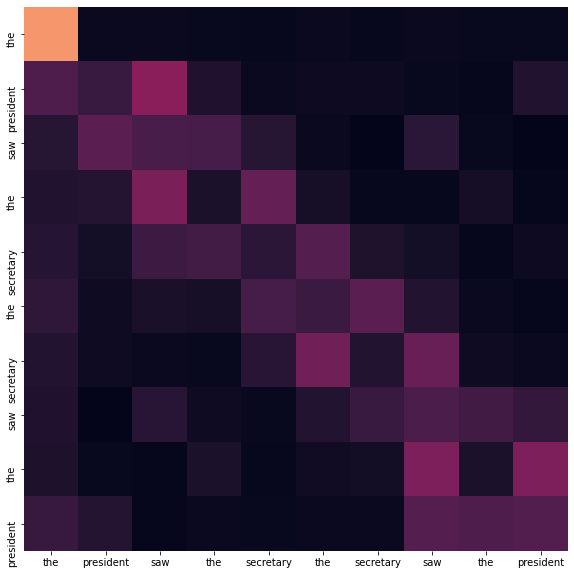

In [108]:
fig, axs = plt.subplots(1,1, figsize=(20, 10))
draw(avg_atts, tok, tok, ax=axs)

In [231]:
# to detect which samples have been answered correctly

for idx, batch in enumerate(tqdm(hans_eval_dl)):
    with torch.no_grad():
        model, batch = put_on_cuda(model, batch)
        model.eval()
        logits = model(**batch)[1].detach().cpu().numpy()
        label_ids = batch['labels'].cpu().numpy()
        preds = np.argmax(logits, axis=1)
        print(idx, np.where(label_ids == preds))

  0%|          | 1/235 [00:00<01:09,  3.36it/s]

0 (array([  4,   6,   7,  15,  16,  19,  35,  36,  38,  39,  40,  41,  42,
        49,  52,  56,  57,  58,  60,  62,  63,  64,  65,  70,  71,  74,
        75,  76,  77,  81,  84,  85,  86,  94,  95,  97,  98,  99, 101,
       105, 106, 107, 108, 110, 111, 112, 113, 117, 118, 120, 121, 123,
       125, 126]),)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


  1%|          | 2/235 [00:00<01:08,  3.41it/s]

1 (array([  2,   5,   8,  10,  13,  14,  19,  22,  23,  24,  36,  39,  41,
        42,  46,  47,  50,  53,  56,  59,  62,  64,  71,  75,  78,  79,
        80,  81,  82,  85,  86,  89,  90,  93,  96,  97,  98, 102, 103,
       104, 107, 108, 109, 111, 112, 122, 123, 124, 125]),)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


  1%|▏         | 3/235 [00:00<01:07,  3.44it/s]

2 (array([  2,   5,   7,   8,   9,  12,  15,  16,  19,  22,  23,  26,  32,
        33,  35,  36,  43,  44,  45,  46,  47,  49,  51,  52,  54,  55,
        57,  58,  60,  61,  62,  65,  69,  72,  73,  75,  79,  82,  87,
        88,  89,  93,  94,  95,  96,  97,  98,  99, 100, 101, 104, 105,
       106, 110, 115, 116, 117, 120, 121]),)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


  2%|▏         | 4/235 [00:01<01:06,  3.46it/s]

3 (array([  0,   1,   6,   8,   9,  11,  14,  16,  23,  25,  26,  27,  28,
        29,  30,  34,  36,  39,  40,  41,  43,  44,  46,  53,  54,  55,
        56,  59,  60,  61,  63,  64,  67,  69,  70,  74,  75,  79,  80,
        82,  83,  84,  88,  91,  92,  93,  94,  96,  97, 105, 106, 107,
       109, 111, 113, 114, 115, 116, 122, 123, 125, 127]),)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


  2%|▏         | 5/235 [00:01<01:06,  3.47it/s]

4 (array([  5,   6,   7,   9,  15,  20,  21,  23,  29,  30,  32,  33,  34,
        35,  36,  37,  39,  41,  42,  43,  44,  46,  48,  49,  51,  52,
        57,  58,  59,  60,  61,  65,  67,  73,  74,  78,  84,  91,  92,
        98, 100, 104, 111, 112, 113, 114, 115, 119, 121, 123, 124, 125]),)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


  3%|▎         | 6/235 [00:01<01:05,  3.48it/s]

5 (array([  4,   6,   7,   8,   9,  10,  11,  14,  17,  19,  20,  21,  22,
        24,  27,  29,  31,  32,  33,  34,  35,  38,  40,  41,  47,  49,
        51,  54,  55,  57,  58,  60,  62,  65,  67,  69,  70,  71,  74,
        76,  77,  81,  82,  83,  86,  88,  92,  94,  96,  98, 100, 101,
       102, 104, 105, 106, 112, 113, 116, 120, 125, 126]),)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


  3%|▎         | 7/235 [00:02<01:05,  3.49it/s]

6 (array([  3,   4,   5,   7,   8,   9,  10,  12,  13,  14,  16,  17,  20,
        21,  23,  24,  25,  31,  33,  35,  37,  38,  40,  41,  45,  46,
        49,  54,  57,  58,  61,  62,  66,  68,  69,  70,  71,  80,  82,
        85,  89,  90,  92,  93,  95,  96, 101, 103, 108, 109, 111, 114,
       118, 121, 127]),)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


  3%|▎         | 8/235 [00:02<01:05,  3.49it/s]

7 (array([  5,   7,   8,   9,  12,  14,  17,  23,  27,  28,  30,  31,  34,
        35,  38,  40,  42,  44,  45,  46,  47,  51,  56,  57,  58,  61,
        64,  72,  76,  79,  81,  87,  89,  90,  92,  93,  97, 100, 108,
       109, 123, 126, 127]),)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


  4%|▍         | 9/235 [00:02<01:04,  3.50it/s]

8 (array([  5,   6,   9,  11,  13,  17,  19,  26,  30,  45,  57,  59,  64,
        69,  70,  80,  83,  85,  86,  87, 102, 103, 107, 126]),)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


  4%|▍         | 10/235 [00:02<01:04,  3.50it/s]

9 (array([  5,  15,  25,  29,  41,  52,  56,  57,  58,  61,  70,  78,  82,
        86, 102, 104, 121, 122, 125, 126]),)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


  5%|▍         | 11/235 [00:03<01:03,  3.50it/s]

10 (array([ 13,  15,  22,  23,  25,  30,  39,  52,  62,  66,  68,  71,  75,
        90,  91,  96,  99, 112, 125]),)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


  5%|▌         | 12/235 [00:03<01:03,  3.50it/s]

11 (array([  4,   6,   8,  12,  16,  27,  29,  37,  50,  63,  68,  80,  83,
        84,  88,  90,  94,  96,  98,  99, 126]),)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


  6%|▌         | 13/235 [00:03<01:03,  3.50it/s]

12 (array([  6,   8,  13,  14,  15,  18,  19,  23,  27,  33,  38,  52,  55,
        59,  74,  77,  89, 115, 116, 124]),)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


  6%|▌         | 14/235 [00:04<01:03,  3.50it/s]

13 (array([ 19,  20,  23,  27,  40,  46,  58,  66,  70,  74,  75,  77,  78,
        79,  80,  88,  93,  94, 103, 106, 110, 114, 115, 118, 119, 120,
       121, 122]),)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


  6%|▋         | 15/235 [00:04<01:02,  3.50it/s]

14 (array([  6,   7,  13,  14,  21,  22,  30,  56,  58,  59,  62,  78,  81,
        85,  86,  90, 104, 115, 120, 121, 124]),)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


  7%|▋         | 16/235 [00:04<01:02,  3.50it/s]

15 (array([  0,   3,   6,   7,  13,  14,  28,  42,  44,  50,  71,  80,  87,
        89,  94,  96,  97,  98, 100, 119, 120, 121, 123, 124]),)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


  7%|▋         | 17/235 [00:04<01:02,  3.50it/s]

16 (array([  6,   7,  12,  17,  22,  23,  27,  30,  37,  38,  41,  46,  49,
        50,  51,  54,  55,  57,  61,  62,  64,  73,  79,  82,  83,  90,
        92,  97, 104, 108, 109, 112, 117, 125]),)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


  8%|▊         | 18/235 [00:05<01:01,  3.50it/s]

17 (array([  3,   4,   9,  11,  13,  19,  25,  27,  32,  48,  50,  53,  57,
        63,  65,  66,  68,  74,  77,  81,  82,  83,  95,  98, 100, 105,
       106, 107, 110, 111, 115, 118, 119, 125, 126]),)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


  8%|▊         | 18/235 [00:05<01:05,  3.31it/s]


KeyboardInterrupt: 

In [172]:
layers_to_check = [0, 6, 8, 11]

Encoder Layer 1


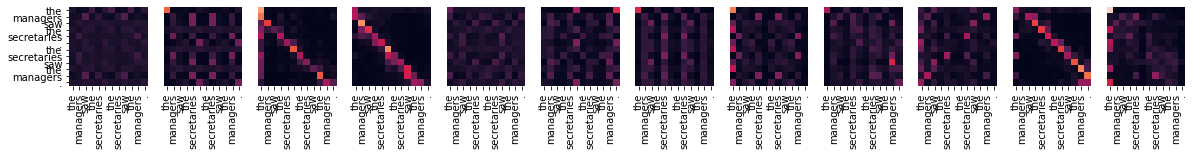

Encoder Layer 2


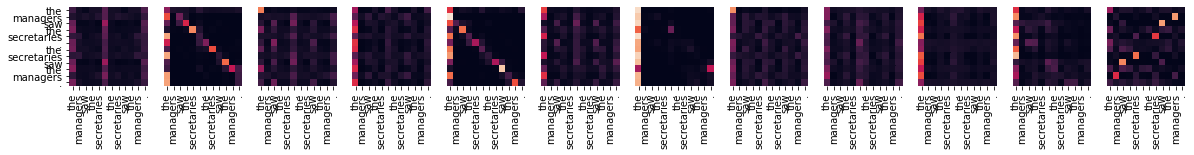

Encoder Layer 3


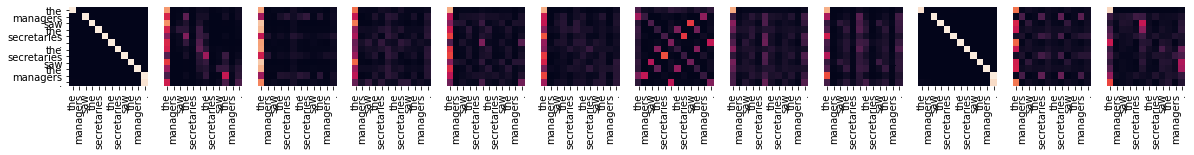

Encoder Layer 4


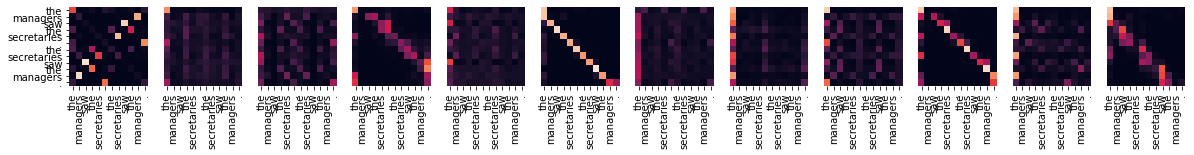

Encoder Layer 5


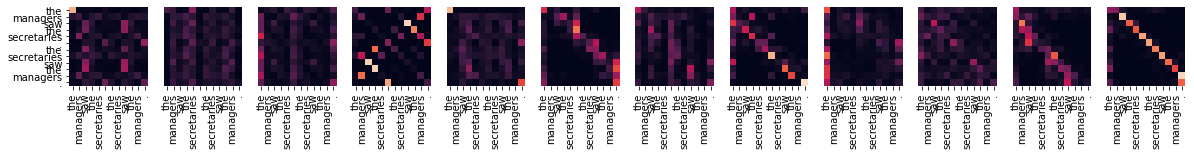

Encoder Layer 6


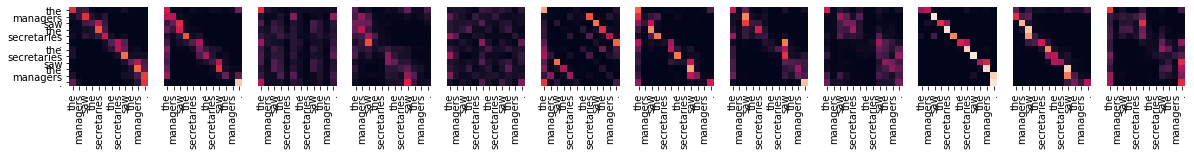

Encoder Layer 7


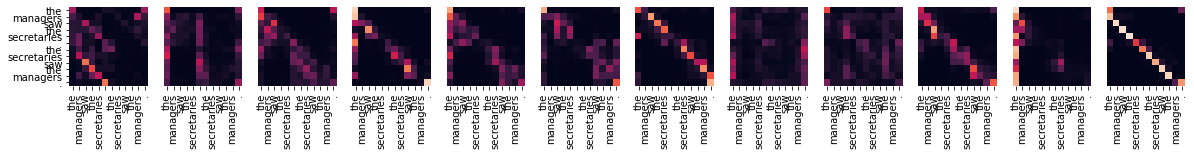

Encoder Layer 8


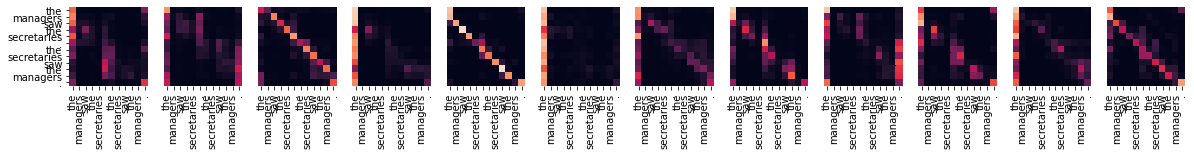

Encoder Layer 9


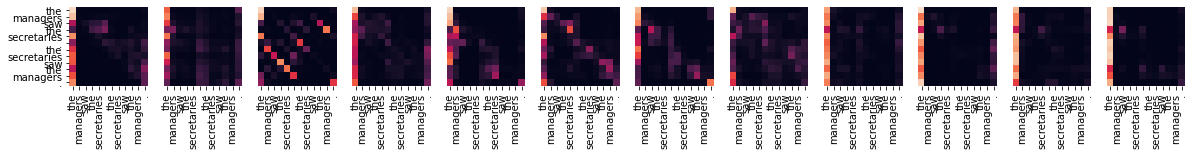

Encoder Layer 10


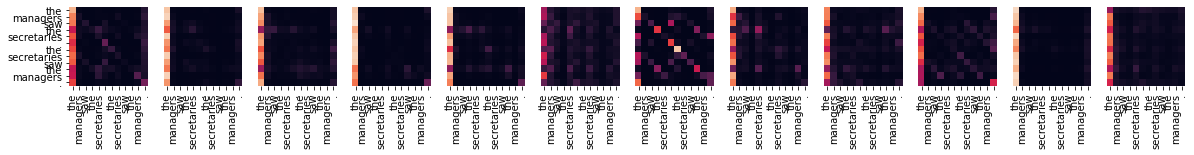

Encoder Layer 11


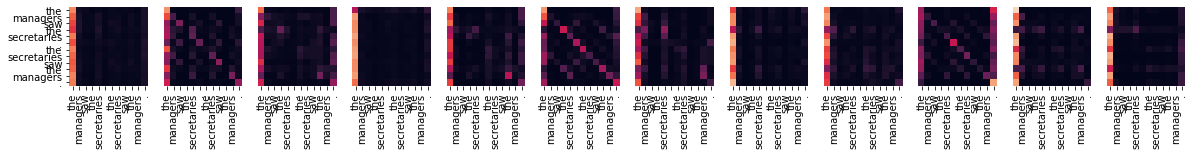

Encoder Layer 12


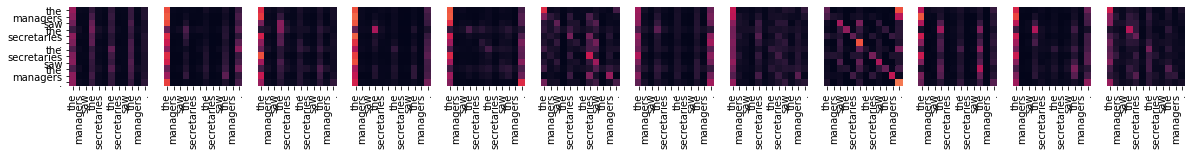

In [173]:
# for layer in range(0, 12, 2):
for layer in range(12):#layers_to_check:
    fig, axs = plt.subplots(1,12, figsize=(20, 10))
    print("Encoder Layer", layer+1)
    for h in range(12):
        draw(attentions[layer][h], 
            tok, tok if h == 0 else [], ax=axs[h], layer=layer, idx=h)
    plt.show()

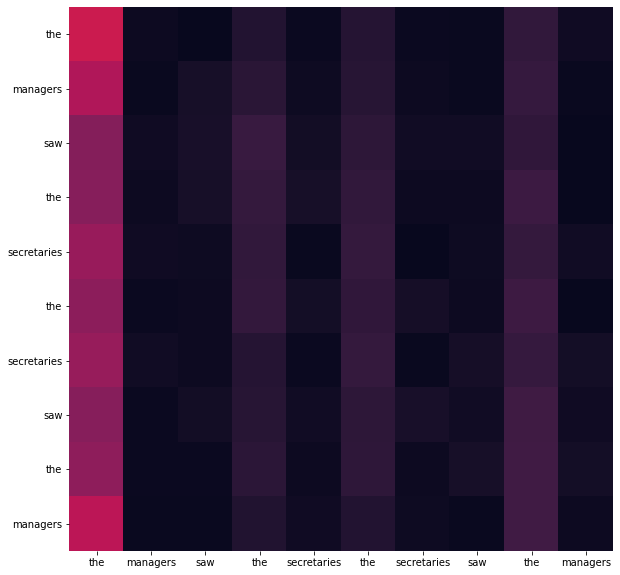

In [218]:
fig, axs = plt.subplots(1,1, figsize=(20, 10))
draw(avg_atts, tok, tok, ax=axs)

## MNLI Attention analysis

In [60]:
mnli_batch = torch.load('/home/nlp/samples.pth')['samples']

In [151]:
label_dict = {0: 'contradiction', 1: 'entailment', 2: 'neutral'}

In [27]:
def get_sample_from_batch(batch, idx):
    sample = {}
    for keys, values in batch.items():
        sample[keys] = values[idx].unsqueeze(0)
    sentence = tokenizer.decode(batch['input_ids'][idx])#, skip_special_tokens = True)
    return sample, sentence

In [28]:
def get_model_preds_and_gt(sample, model_path, label_dict):
    model = AutoModelForSequenceClassification.from_pretrained(model_path)
    model, sample = put_on_cuda(model, sample)
    logits = model(**sample)[1].detach().cpu().numpy()
    output = np.argmax(logits, axis=1)
    return label_dict[output[0]], label_dict[sample['labels'].item()]

In [29]:
def get_attention(model, sample):
    model, sample = put_on_cuda(model, sample)
    sample.pop('labels')
    output = model(**sample)[2:]
    return output

In [160]:
sample, sentence = get_sample_from_batch(batch, 15)

In [120]:
model_pred, gt = get_model_preds_and_gt(sample, MODEL_PATH_SMALL, label_dict)

In [161]:
sentence, model_pred, gt

("[CLS] i'm not sure what the overnight low was [SEP] i don't know how cold it got last night. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]",
 'neutral',
 'entailment')

In [7]:
text_a = "look, there's a legend here"
text_b = "see, there is a well known hero here"
tok1 = tokenizer.tokenize(text_a)
tok2 = tokenizer.tokenize(text_b)
tok = tok1+tok2

In [9]:
model_name_or_path = MODEL_PATH_BIG

In [10]:
config = AutoConfig.from_pretrained(model_name_or_path, output_attentions=True)
model = AutoModelForSequenceClassification.from_pretrained(model_name_or_path, config=config).eval().cuda()

In [11]:
ids = torch.tensor(tokenizer.convert_tokens_to_ids(tok)).unsqueeze(0).to('cuda')
output = model(ids)
attentions = torch.cat(output[1]).to('cpu').detach().numpy()
preds = np.argmax(output[0].cpu().detach(), axis=1)

In [12]:
atts = [attentions[0][2], attentions[0][3], attentions[0][10],\
        attentions[1][1], attentions[1][4], attentions[1][11], \
        attentions[2][0], attentions[2][6], attentions[2][9], \
        attentions[3][0], attentions[3][3], attentions[3][5], attentions[3][9], \
        attentions[3][11], \
        attentions[4][3], attentions[4][5], attentions[4][7], attentions[4][10], \
        attentions[4][11], \
        attentions[5][0], attentions[5][1], attentions[5][5], attentions[5][6], \
        attentions[5][7], attentions[5][9], attentions[5][10],\
        attentions[6][0], attentions[6][2], attentions[6][3], \
        attentions[6][5], attentions[6][6], attentions[6][9], attentions[6][11], \
        attentions[7][2], attentions[7][4], attentions[7][7], attentions[7][11], \
        attentions[8][2], \
        attentions[9][6]]

avg_atts = sum(atts)/len(atts)

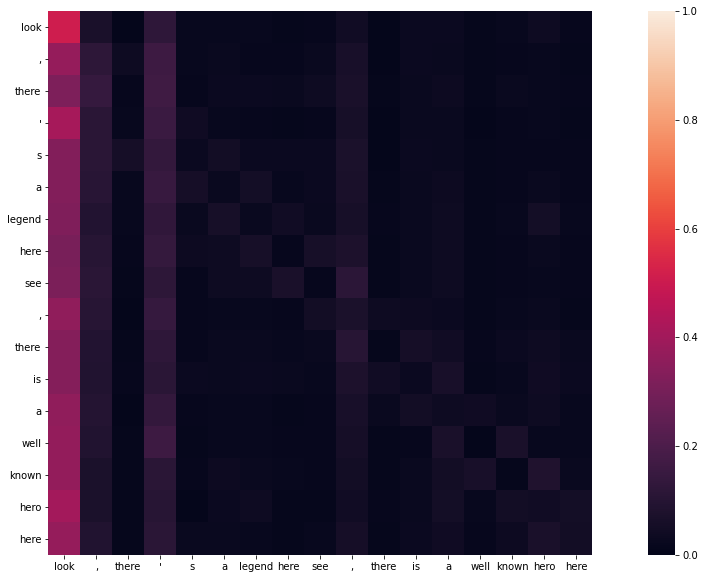

In [15]:
fig, axs = plt.subplots(1,1, figsize=(20, 10))
draw(avg_atts, tok, tok, ax=axs, cbar=True)

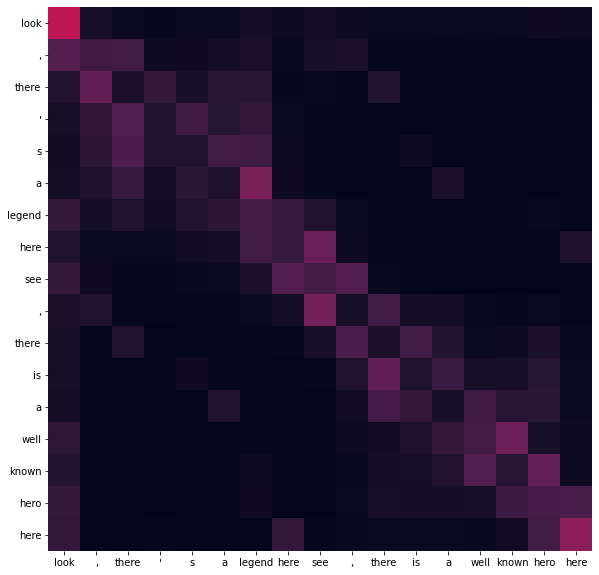

In [126]:
fig, axs = plt.subplots(1,1, figsize=(20, 10))
draw(avg_atts, tok, tok, ax=axs, cbar)